#### Can identifying families with children help boost the accuracy?

For the classificiation purpose in the data competition, the value of demographic information implied by the ticket combination in the Kaggle Titanic data set (hereafter, the Titanic data) is widely understated. In this post, I'm going to show you how to expose demographic information hidden in the full data set (the join of the training set and test set) of the Titanic data, and hopefully help us boost our prediction accuracy.

Note: If you are concerned about data leakage that araises in data processing before splitting the data set, you may find this [discussion](https://www.kaggle.com/c/titanic/discussion/41928#235524) interesting. For the purose that is more of winning the competition than generalization, I'll simply use the full data set as the basis of feature eningeering and leave the data leakage judgement for you.

Here is a list of observations I'm going to point out with advanced tricks of Pandas in conjunction with NumPy:

#### EDA

In [49]:
##
# Library we need 
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Configure Visualization Defaults
mpl.style.use('ggplot')
pylab.rcParams['figure.figsize'] = 12, 8
sns.set_style('white')
pd.set_option('display.max_columns', None)

In [50]:
# Replace the following two directories with those in the following comments
df_train = pd.read_csv(r'F:\GitHubData\Titanic\train.csv') # r"../input/train.csv"
df_test = pd.read_csv(r'F:\GitHubData\Titanic\test.csv') # r"../input/test.csv"

# inconsistent columns so we 
# use concat, rather than pd.merge(df_train, df_test, on = [...], how = 'inner')
df_all = pd.concat([df_train, df_test], join='outer', axis=0) 
df_train.name = 'Training data'
df_test.name = 'Test data'

# We have 11 features and 1 target variables
print(df_train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
None


In [51]:
# Dataset Dimensions
print(f'Number of Training Examples: {df_train.shape[0]}')
print(f'Number of Test Examples = {df_test.shape[0]}')
print(f'Shape of Training Examples = {df_train.shape}')
print(f'Shape of Test Examples = {df_test.shape}')

Number of Training Examples: 891
Number of Test Examples = 418
Shape of Training Examples = (891, 12)
Shape of Test Examples = (418, 11)


In [52]:
# Column name we have
print(sorted(df_train.columns.tolist())) 
print(sorted(df_test.columns.tolist()))

['Age', 'Cabin', 'Embarked', 'Fare', 'Name', 'Parch', 'PassengerId', 'Pclass', 'Sex', 'SibSp', 'Survived', 'Ticket']
['Age', 'Cabin', 'Embarked', 'Fare', 'Name', 'Parch', 'PassengerId', 'Pclass', 'Sex', 'SibSp', 'Ticket']


In [53]:
# Numeric variables in training set
print(df_train.describe(include=[np.number]).T)
print('-' * 30)
# Categorical variables in training set
print(df_train.describe(include=['O']).T)

             count        mean         std   min       25%       50%    75%  \
PassengerId  891.0  446.000000  257.353842  1.00  223.5000  446.0000  668.5   
Survived     891.0    0.383838    0.486592  0.00    0.0000    0.0000    1.0   
Pclass       891.0    2.308642    0.836071  1.00    2.0000    3.0000    3.0   
Age          714.0   29.699118   14.526497  0.42   20.1250   28.0000   38.0   
SibSp        891.0    0.523008    1.102743  0.00    0.0000    0.0000    1.0   
Parch        891.0    0.381594    0.806057  0.00    0.0000    0.0000    0.0   
Fare         891.0   32.204208   49.693429  0.00    7.9104   14.4542   31.0   

                  max  
PassengerId  891.0000  
Survived       1.0000  
Pclass         3.0000  
Age           80.0000  
SibSp          8.0000  
Parch          6.0000  
Fare         512.3292  
------------------------------
         count unique                       top freq
Name       891    891  Mannion, Miss. Margareth    1
Sex        891      2                 

In [54]:
# Missing values
def displayMissing(df):
    for col in df.columns.tolist():
        print(f'{col:11s} NO. missing values: {df[col].isnull().sum()}')

for i, df in enumerate([df_train, df_test]):
    print(f'{df.name}')
    displayMissing(df)
    if i == 0: print('-' * 30) 

Training data
PassengerId NO. missing values: 0
Survived    NO. missing values: 0
Pclass      NO. missing values: 0
Name        NO. missing values: 0
Sex         NO. missing values: 0
Age         NO. missing values: 177
SibSp       NO. missing values: 0
Parch       NO. missing values: 0
Ticket      NO. missing values: 0
Fare        NO. missing values: 0
Cabin       NO. missing values: 687
Embarked    NO. missing values: 2
------------------------------
Test data
PassengerId NO. missing values: 0
Pclass      NO. missing values: 0
Name        NO. missing values: 0
Sex         NO. missing values: 0
Age         NO. missing values: 86
SibSp       NO. missing values: 0
Parch       NO. missing values: 0
Ticket      NO. missing values: 0
Fare        NO. missing values: 1
Cabin       NO. missing values: 327
Embarked    NO. missing values: 0


As pointed out in many exploratory data analysis on Kaggle Titanic data set, we have missing values in continuous features `Age` and `Fare` and nominal variables `Embarked` and `Cabin`. 

#### Ticket combination

In [55]:
# todo:  Ticket combination is the feature without any missing values.
# We should try to extract any information from it
# although it appears useless at the first glance.
def getTicketPrefixAndNumber(df, col):
    # naming the columns to be created
    col_num = col + '_num'
    col_alp = col + '_alp'

    # get the last group of contiguous digits
    # vectorize string function with str method
    # get any contignuous nuemrical digits from the end
    # return anything that matches the pattern specified inside the parenthesis 
    df[col_num] = df[col].str.extract(r'(\d+)$')
    df[col_num].fillna(-1, inplace=True)

    # get the complete string before a space that is followed by a trailing number group
    df[col_alp] = df[col].str.extract(r'(.*)\ \d+$')
    # sidenote: .replace({'\.': '', '/': ''}, regex=True)
    df[col_alp].fillna('M', inplace=True)
    return df

getTicketPrefixAndNumber(df_all, 'Ticket').head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Ticket_num,Ticket_alp
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,21171,A/5
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,17599,PC
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,3101282,STON/O2.
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,113803,M
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,373450,M


In [56]:
print(df_all.Ticket_num.describe())
print('-' * 30) 
df_all['Ticket_num'] = pd.to_numeric(df_all['Ticket_num'])
print(df_all.Ticket_num.describe())

count     1309
unique     924
top       2343
freq        11
Name: Ticket_num, dtype: object
------------------------------
count    1.309000e+03
mean     2.830713e+05
std      6.353943e+05
min     -1.000000e+00
25%      1.356700e+04
50%      1.108130e+05
75%      3.470750e+05
max      3.101317e+06
Name: Ticket_num, dtype: float64


In [57]:
# check to see if the string decomposition works as expected.
colnames = ['Ticket' + s for s in ['', '_num', '_alp']]
df_all[colnames].head()

,Ticket,Ticket_num,Ticket_alp
0,A/5 21171,21171,A/5
1,PC 17599,17599,PC
2,STON/O2. 3101282,3101282,STON/O2.
3,113803,113803,M
4,373450,373450,M


#### Travel group
Are there any people sharing the same ticket number but actually come from different travel groups (identified by ticket combination)? The answer is Yes. In such a case, I use `Ticket`, rather than `Ticket_num` to define a travel group. Using `last name` to define a travel group as seen in many kernels is not good enough for my purpose. People travelling together as a group should bear similar characteristics related to their survival rates in this travel disaster. Members of a travel group do not necessary share biological relathinship.

In [58]:
islice = df_all.groupby('Ticket_num')['Ticket_alp'].transform(lambda x: x.nunique() > 1)
df_all.loc[islice,:].sort_values(by=['Ticket_num']).head(6)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Ticket_num,Ticket_alp
226,227,1.0,2,"Mellors, Mr. William John",male,19.0,0,0,SW/PP 751,10.50,NaN,S,751,SW/PP
648,649,0.0,3,"Willey, Mr. Edward",male,NaN,0,0,S.O./P.P. 751,7.55,NaN,S,751,S.O./P.P.
570,571,1.0,2,"Harris, Mr. George",male,62.0,0,0,S.W./PP 752,10.50,NaN,S,752,S.W./PP
155,1047,NaN,3,"Duquemin, Mr. Joseph",male,24.0,0,0,S.O./P.P. 752,7.55,NaN,S,752,S.O./P.P.
279,280,1.0,3,"Abbott, Mrs. Stanton (Rosa Hunt)",female,35.0,1,1,C.A. 2673,20.25,NaN,S,2673,C.A.
746,747,0.0,3,"Abbott, Mr. Rossmore Edward",male,16.0,1,1,C.A. 2673,20.25,NaN,S,2673,C.A.


#### Survival rate
Check to see if survival rate (based on available Survived feature) varies across ticket combinations.

In [59]:
gtb1 = df_all[['Survived', 'Ticket']].groupby(['Ticket'])
# compute the groupwise survival rates (percentage) # pd.count() counts non-NA cells
temp = (gtb1['Survived'].sum() / gtb1['Survived'].count() * 100).sort_values()
# name the resulting column to be used in the merge below
temp.name = 'TeamSurvivalRate'
# one-to-many merge on column Ticket
df_all = pd.merge(df_all, temp, on='Ticket')

#### Size of family and travel group
Check if there exist travel groups with members of size larger than 5.

Note: `pd.count()` doesn't count NA cells. If use it rather than `pd.size()` to count group size on Survived feature, the resulting group size is not correct.

In [60]:
df_all.loc[df_all.groupby('Ticket')['Survived'].transform('size') > 5, :]['Ticket'].unique()

array(['347082', '382652', '347077', '19950', '3101295', 'CA 2144',
       '347088', 'S.O.C. 14879', '1601', 'CA. 2343', '113781', 'PC 17608'],
      dtype=object)

For example, the travel group of ticket combination `S.O.C. 14879` has more than five members (two of which have unknown Survived features).

In [61]:
df_all.loc[df_all.Ticket=='S.O.C. 14879',['Ticket', 'Survived']]

,Ticket,Survived
149,S.O.C. 14879,0.0
150,S.O.C. 14879,0.0
151,S.O.C. 14879,0.0
152,S.O.C. 14879,0.0
153,S.O.C. 14879,0.0
154,S.O.C. 14879,NaN
155,S.O.C. 14879,NaN


For example, the family of ticket combination `PC 17608` travles in a group with two other non-biological relationship members `PassengerId` = 951 and 1267.

In [62]:
df_all.loc[df_all['Ticket'] == 'PC 17608',:]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Ticket_num,Ticket_alp,TeamSurvivalRate
504,312,1.0,1,"Ryerson, Miss. Emily Borie",female,18.0,2,2,PC 17608,262.375,B57 B59 B63 B66,C,17608,PC,100.0
505,743,1.0,1,"Ryerson, Miss. Susan Parker ""Suzette""",female,21.0,2,2,PC 17608,262.375,B57 B59 B63 B66,C,17608,PC,100.0
506,916,NaN,1,"Ryerson, Mrs. Arthur Larned (Emily Maria Borie)",female,48.0,1,3,PC 17608,262.375,B57 B59 B63 B66,C,17608,PC,100.0
507,951,NaN,1,"Chaudanson, Miss. Victorine",female,36.0,0,0,PC 17608,262.375,B61,C,17608,PC,100.0
508,956,NaN,1,"Ryerson, Master. John Borie",male,13.0,2,2,PC 17608,262.375,B57 B59 B63 B66,C,17608,PC,100.0
509,1034,NaN,1,"Ryerson, Mr. Arthur Larned",male,61.0,1,3,PC 17608,262.375,B57 B59 B63 B66,C,17608,PC,100.0
510,1267,NaN,1,"Bowen, Miss. Grace Scott",female,45.0,0,0,PC 17608,262.375,NaN,C,17608,PC,100.0


Besides, here is the biggest family/group in the Titanic data:

In [63]:
df_all.loc[df_all['Ticket'] == 'CA. 2343',:]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Ticket_num,Ticket_alp,TeamSurvivalRate
283,160,0.0,3,"Sage, Master. Thomas Henry",male,NaN,8,2,CA. 2343,69.55,NaN,S,2343,CA.,0.0
284,181,0.0,3,"Sage, Miss. Constance Gladys",female,NaN,8,2,CA. 2343,69.55,NaN,S,2343,CA.,0.0
285,202,0.0,3,"Sage, Mr. Frederick",male,NaN,8,2,CA. 2343,69.55,NaN,S,2343,CA.,0.0
286,325,0.0,3,"Sage, Mr. George John Jr",male,NaN,8,2,CA. 2343,69.55,NaN,S,2343,CA.,0.0
287,793,0.0,3,"Sage, Miss. Stella Anna",female,NaN,8,2,CA. 2343,69.55,NaN,S,2343,CA.,0.0
288,847,0.0,3,"Sage, Mr. Douglas Bullen",male,NaN,8,2,CA. 2343,69.55,NaN,S,2343,CA.,0.0
289,864,0.0,3,"Sage, Miss. Dorothy Edith ""Dolly""",female,NaN,8,2,CA. 2343,69.55,NaN,S,2343,CA.,0.0
290,1080,NaN,3,"Sage, Miss. Ada",female,NaN,8,2,CA. 2343,69.55,NaN,S,2343,CA.,0.0
291,1234,NaN,3,"Sage, Mr. John George",male,NaN,1,9,CA. 2343,69.55,NaN,S,2343,CA.,0.0
292,1252,NaN,3,"Sage, Master. William Henry",male,14.5,8,2,CA. 2343,69.55,NaN,S,2343,CA.,0.0


In [64]:
# If use it rather than `pd.size()` to count group size on Survived feature, 
# the resulting group size is not correct.
df_all.loc[df_all.groupby('Ticket')['Survived'].transform('count') > 5, :]['Ticket'].unique()

array(['347082', '3101295', 'CA 2144', '347088', '1601', 'CA. 2343'],
      dtype=object)

Trave group varies in size. I create a feature `TeamSize` to count the total number of people in a group of the same ticket comibnation. For the estimate of family size, it is pretty straightforward to account for the entry itself in addition to the number of its siblings, parents and childrens.

In [65]:
df_all['TeamSize'] = df_all.groupby('Ticket')['Survived'].transform(lambda x: x.shape[0]) # ~ x.size

In [66]:
# The correct size of a family
df_all['FamilySize'] = df_all['SibSp'] + df_all['Parch'] + 1

More than $76\%$ of travel groups are composed of one person only. 

In [67]:
# To have a sense of the distribution of TeamSize
g = df_all.groupby(['Ticket']).first()['TeamSize'].value_counts()
ans = g / g.sum() * 100 # convert to percentrage
# Tabularize
ans.index = ans.index.astype(int)
ans.index.name = 'Group Size'
pd.DataFrame(ans).rename(columns={'TeamSize': 'Percentage'}).T

Group Size,1,2,3,4,5,7,6,8,11
Percentage,76.749193,14.208827,5.274489,1.722282,0.753498,0.538213,0.430571,0.215285,0.107643


The following code shows that team size might be a useful predictor for survival rates.

In [68]:
df_all.groupby(['TeamSize','Ticket'])['TeamSurvivalRate'].mean().groupby(level=0).mean()

TeamSize
1.0     27.027027
2.0     50.847458
3.0     65.248227
4.0     68.750000
5.0     39.285714
6.0     25.000000
7.0     35.000000
8.0     35.714286
11.0     0.000000
Name: TeamSurvivalRate, dtype: float64

In [69]:
df_all.groupby(['Pclass', 'TeamSize'])['TeamSurvivalRate'].mean()

Pclass  TeamSize
1       1.0          44.444444
        2.0          65.217391
        3.0          76.666667
        4.0          80.208333
        5.0          58.333333
        6.0          50.000000
        7.0         100.000000
2       1.0          38.202247
        2.0          51.515152
        3.0          72.222222
        4.0          70.833333
        5.0         100.000000
        7.0           0.000000
3       1.0          20.000000
        2.0          33.333333
        3.0          52.500000
        4.0          43.750000
        5.0           0.000000
        6.0           0.000000
        7.0          25.000000
        8.0          35.714286
        11.0          0.000000
Name: TeamSurvivalRate, dtype: float64

Based on the estimated group survival rate, regardless of passenger class, the top three groups tend to include groups of size four and three.

In [70]:
# This code results in the sorting of Teamsize within passenger class by team survival rate.
print(df_all.groupby(['Pclass', 'TeamSize'])['TeamSurvivalRate'].mean(). \
    reset_index().sort_values(by=['Pclass','TeamSurvivalRate']))

    Pclass  TeamSize  TeamSurvivalRate
0        1       1.0         44.444444
5        1       6.0         50.000000
4        1       5.0         58.333333
1        1       2.0         65.217391
2        1       3.0         76.666667
3        1       4.0         80.208333
6        1       7.0        100.000000
12       2       7.0          0.000000
7        2       1.0         38.202247
8        2       2.0         51.515152
10       2       4.0         70.833333
9        2       3.0         72.222222
11       2       5.0        100.000000
17       3       5.0          0.000000
18       3       6.0          0.000000
21       3      11.0          0.000000
13       3       1.0         20.000000
19       3       7.0         25.000000
14       3       2.0         33.333333
20       3       8.0         35.714286
16       3       4.0         43.750000
15       3       3.0         52.500000


In [71]:
# We can further obtain the class-wise top three groups in terms of team survival rate.
# Just append "groupby(['Pclass']).tail(3)".
print(df_all.groupby(['Pclass', 'TeamSize'])['TeamSurvivalRate'].mean(). \
    reset_index().sort_values(by=['Pclass','TeamSurvivalRate']).groupby(['Pclass']).tail(3))

    Pclass  TeamSize  TeamSurvivalRate
2        1       3.0         76.666667
3        1       4.0         80.208333
6        1       7.0        100.000000
10       2       4.0         70.833333
9        2       3.0         72.222222
11       2       5.0        100.000000
20       3       8.0         35.714286
16       3       4.0         43.750000
15       3       3.0         52.500000


#### Credibility of group survival rate
The credibility of a group survival rate is measured in terms of the proportion of valid `Survived` feature. I will use it as a weight to adjust the `TeamSurvivalRate` feature.

In [72]:
def getCredibilitySurvivalRate(df):
    # Use `size` or `shape[0]` to get the full length of a series
    # When summing over cells of {0,1,NaN}, 
    # regardless of the use of `pd.notnull()`, the outcome is identical.
    df['SRcredibility'] = pd.notnull(df['Survived']).sum() / df['Survived'].size 
    return df

df_all = df_all.groupby('Ticket').apply(getCredibilitySurvivalRate)

#### Type of family roles
For flexibility in tuning hyper parameters like the age threshold for the definition of a child, I introduce the `cutoff` argument for the maximum child age and set the default cutoff age to 7. Then I do something like a grid search on the integer interval $[1, 29]$ to see the impact of the cutoff age configuratio on the estimate of survival rates by gender.

In [73]:
def getRole(df, cutoff=7):
    df['Role'] = 'Man'
    df.loc[df['Sex'] == 'female', 'Role'] = 'Woman'
    df.loc[df['Age'] <= cutoff, 'Role'] = 'Child'
    return df

ans = []
ages = range(1, 30)
for cut in ages:
    getRole(df_all, cutoff=cut)
    g = df_all.groupby(['Role'])
    # [1] I covert the resulting Pandas series to a data frame object and then append
    # it to the `ans` list object so that I can concatenate them in one step. later.
    ans.append((g['Survived'].sum() / g['Survived'].count()).to_frame())

In [74]:
# [2] To concatnate the data frames stored in the `ans` list object.
temp = pd.concat(ans, axis=1)  # 3 by N (=len(ages))
# [3] convert 3 by N table to N by 3 table
tb1 = pd.DataFrame(np.array(temp).T,
                   columns=['Child', 'Man', 'Woman'], index=ages)  # N by 3
tb1.index.name = 'Age'
# [4] melt the table tb1 for drawing a line plot
tb1.reset_index(inplace=True)  # prep for melt
tb2 = pd.melt(tb1, id_vars=['Age'], value_vars=['Child', 'Man', 'Woman'],
              var_name='Role', value_name='Survival')

Here I'm going to use seaborn facetGrid for drawing the line plot ([searborn.FaceGrid](https://seaborn.pydata.org/generated/seaborn.FacetGrid.html) document).

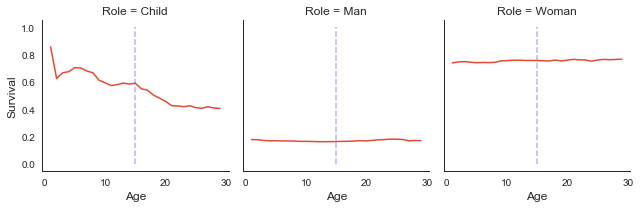

In [75]:
# [5] FacetGrid and mapping plot functions to each grid
g = sns.FacetGrid(tb2, col='Role', margin_titles=True)
g = g.map(plt.plot, 'Age', 'Survival')

# add vertical line
axes = g.fig.axes
for ax in axes:
    ax.vlines(x=15, ymax=1, ymin=0, linestyles='dashed', alpha=0.3, colors='blue')
plt.show()

The child survival rate is trending downward as the maximum age of children is lowered. I want to maximize the number of children with the constraint to maintain the child survival rate at least $60\%$, so I set the hyper parameter of child age to 15.

In [76]:
getRole(df_all, cutoff=15);

#### Adults traveling with children

In [78]:
# Use this as an example: df_all.loc[df_all['Ticket_num']==17608,:]
# Step 1. Create a new column for the number of siblings of a child.
df_all['childSibSp'] = np.where(df_all['Role'] == 'Child', df_all['SibSp'], 0)

In [91]:
# Step 2. Is the childSibSp value unique within a travel group? Answer: Yes
logic = df_all['childSibSp']>0 # screen out parents (whose SibSp is at least one) 
df_all.loc[logic,:].groupby('Ticket')['childSibSp'].nunique().value_counts()

1    37
Name: childSibSp, dtype: int64

So, We can use childSibSp to identify siblings of a child.

stop here! ---------------------------------------------

In [ ]:
# Step 3. Broadcasting: in a group, let every entry can see the shared 'childSibSp' value.
df_all['childSibSp'] = df_all.groupby('Ticket')['childSibSp'].transform('max')
# 'cz otherwise it's 0 by default.

In [ ]:
# Step 4. If an example's SibSp equals to the shared value, the example must
# from a elder child of age greater than the age limit for the child definition.
logic = (df_all['SibSp'] != 0) & \
        (df_all['SibSp'] == df_all['childSibSp']) &\
        (df_all['Role'] != 'Child')
df_all.loc[logic, 'Role'] = 'olderChild'

In [ ]:
# todo: who is the female household head and/or the male household head?
# Step 1. Identify the FamilySize value of the youngest child in each travel team.
df_all['childFamilySize'] = np.where(df_all['Role'].isin(['Child', 'olderChild']),
                                     df_all['FamilySize'], 0)
# Step 2. Broadcasting the FamilySize value of the youngest child to
# other members in the same travel team
df_all['childFamilySize'] = df_all.groupby('Ticket')['childFamilySize'].transform('max')

In [ ]:
# Step 3. identy people who are parents
def isMotherOrFather(s):
    return 'Father' if s == 'Man' else 'Mother'

In [ ]:
slice_logic = ((df_all['FamilySize'] == df_all['childFamilySize']) & \
               (~df_all['Role'].isin(['Child', 'olderChild'])) & \
               (df_all['FamilySize'] > 0))
# a trick to obtain the index of valid examples after logical operations
slice_index = df_all.loc[slice_logic, :].index
df_all.loc[slice_index, 'Role'] = \
    df_all.loc[slice_logic, :]['Role'].apply(isMotherOrFather)

In [ ]:
df_all['ChildWAdult'] = 'Not Applicable'
logic = (df_all['Role'].isin(['Child', 'olderChild']))
df_all.loc[logic, 'ChildWAdult'] = np.where(
    df_all.loc[logic, 'FamilySize'] > df_all.loc[logic, 'childSibSp'] + 1,
    'Yes',
    'No'
)

#### Number of children per travel group

In [ ]:
# todo: How many children in this group?
#Method 1.
df_all['NumChild'] = df_all.groupby('Ticket')['Role'].\
    transform(lambda x: x.isin(['Child', 'olderChild']).sum())
df_all['NumYoungChild'] = df_all.groupby('Ticket')['Role'].\
    transform(lambda x: x.isin(['Child']).sum())

In [ ]:
"""
#Method 2.
numChildDict = df_all.groupby('Ticket')['Age']\
    .apply(lambda x: (x <= cutoffChildAge).sum()).reset_index(name='NumChild')
df_all.join(numChildDict, on='Ticket')
"""

In [ ]:
# Although the survival rate by number of child varies, the highest survival rate
# falls in family of three children and it holds across classes.
print(df_all.groupby(['Pclass', 'NumChild'])['Survived'].mean())
# So, number of children should be another good predictor;
# In passenger classes 1 and 2, families with three children have higher
# estimated survival rates.

todo: travel with dad, mom, or both? Is with mother better than with father? NO.

This works
Note: if you move ['Role'] inside transform's lambda function, it fails.
Below I compare two different approaches for completing similar logical
operation tasks.

In [ ]:
# 1. The usual method for broadcasting simple logical operations.
df_all['hasMother'] = df_all.groupby('Ticket')['Role'].\
    transform(lambda x: (x == 'Mother').sum() > 0)
df_all['hasFather'] = df_all.groupby('Ticket')['Role'].\
    transform(lambda x: (x == 'Father').sum() > 0)
df_all['hasBothParents'] = np.where(
    df_all['hasMother'] & df_all['hasFather'],
    True,
    False
)

In [ ]:
# 2. Advanced Method: more complicated logical operations
logics = [(df_all['hasFather'] & ~df_all['hasMother'], 'with Father'),
          (df_all['hasFather'] & df_all['hasMother'], 'with Both'),
          (~df_all['hasFather'] & df_all['hasMother'], 'with Mother'),
          (~df_all['hasFather'] & ~df_all['hasMother'], 'without Parents')]
for logic, s in logics:
    ans = df_all.loc[df_all['Age'] <= 10, :].loc[logic, :].\
        groupby('Ticket')['Survived'].mean().mean()
    print(f"{s:>15} {ans: .2f}")

In [ ]:
"""
# Sanity check for only father groups
index = df_all.loc[df_all['hasFather'],:].index
df_all.loc[index,:].groupby('Ticket_num').groups.keys()
df_all.loc[df_all['Ticket_num']==2079,:]
"""

In [ ]:
"""
# See this link: https://medium.com/@ODSC/creating-if-elseif-else-variables-in-python-pandas-7900f512f0e4

#Method 1. Not exactly what I want; it only identify the entry of mother, but
#I want the result to be broadcasted to everyone in the same group.
role = 'Mother'
#Step 1. Identify a mother's life status
conditions = [(df_all['Role'] != role), # 'Not applicable'
              (df_all['Survived'].isnull()), # 'Unknown'
              (df_all['Survived'] == 1.0), # 'Yes'
              (df_all['Survived'] == 0.0) # 'No'
              ]
choices = ['Not applicable', 'Unknown', 'Yes', 'No']
df_all['isMotherSurvived'] = np.select(conditions, choices)
len(df_all[df_all['Role']=='Mother']['isMotherSurvived'].values) # 44 mothers on board

#Step 2. "Braodcast" the group-specific result to other group members
#Method 1. Use map + dictionary
index = df_all[df_all['Role']=='Mother']['Ticket_num'] # step 1-1. get the index
ss = pd.Series(df_all[df_all['Role']=='Mother']['isMotherSurvived'].values, index=index) # step 1-2. get the value
df_all['isMotherSurvived'] = df_all['Ticket_num'].map(ss.to_dict()).fillna('not applicable') # step 1-3. use dictionary to update the rest

#Method 2.
#https://stackoverflow.com/questions/56708924/broadcast-value-to-dataframe-group-by-condition
df_all['test3'] = df_all['isMotherSurvived'].where(df_all['Role'].eq('Mother'))\
    .groupby(df_all['Ticket_num']).transform('first').fillna('not applicable')
"""

The compact version based on the preceding uncommented methods 1 and 2.
So, we can do it automatically based on the experimental code block above.

In [ ]:
role = 'Mother'
def isSurvived(df_all, role='Mother'):
    # Step 1. Identify a mother's life status
    conditions = [(df_all['Role'] != role),  # 'Not applicable'
                  (df_all['Survived'].isnull()),  # 'Unknown'
                  (df_all['Survived'] == 1.0),  # 'Yes'
                  (df_all['Survived'] == 0.0)  # 'No'
                  ]
    choices = ['Not applicable', 'Unknown', 'Yes', 'No']
    s = 'is' + role + 'Survived'
    df_all[s] = np.select(conditions, choices)
    df_all[s] = df_all[s].where(df_all['Role'].eq(role)) \
        .groupby(df_all['Ticket_num']).transform('first').fillna('not applicable')
    return df_all

In [ ]:
roles = ['Mother', 'Father']
for role in roles:
    isSurvived(df_all, role=role)

todo: get the prefix of Cabin feature.

In [ ]:
def getCabinPrefix(df):
    # 'M' is assigned to missing values
    df['Deck'] = df['Cabin'].apply(lambda s: s[0] if pd.notnull(s) else 'M')
    return df

In [ ]:
getCabinPrefix(df_all)
df_all['Deck'].unique()

In [ ]:
"""
# def imputeCabinePrefix(df_all):
df_all['Deck'].value_counts()

# Check to see if the 2nd half of the combined table are all NaN Survived data
# (1) iloc works with slicing that includes right endpoint.
# (2) iloc works with index only, so even though I need 'Survived, I use it separately.
# (3) isnull() to see if there is any missing value
df_all.iloc[df_train.shape[0]:, ]['Survived'].isnull().all()

# Cabin numbers have clusters
df_all['Cabin'].value_counts()
# For example, 'B57 B59 B63 B66' corresponds to five persons
# in the Ryerson family. People in the same cabin share the same
# Ticket_alp and Ticket_num. These three variables should be highly
# correlated.
df_all.loc[df_all['Cabin'] == 'B57 B59 B63 B66']
# 'B57 B59 B63 B66' maps to Ticket_alp = 'PC', which is a much larger group.
df_all.loc[df_all['Ticket_alp'] == 'PC']['Survived'].sum()

# We may check later whether each group can be identified or associated with higher servival rate
# We may also check to see if couples have higher survival rates
# Check Family Ryerson. The number of SibSp and Parch might have more information.
"""

todo: extract names and titles

In [ ]:
def getLastNameAndTitle(df):
    # (1) https://docs.python.org/2/library/re.html
    # (2) Why this patterns works? See the [reason](https://shorturl.at/uAEM8).
    # (3) This pattern works as well r'^([^,]*)'
    # See the reference [link](https://shorturl.at/dwJMS)
    df['LastName'] = df['Name'].str.extract(r'^(.+?),')
    df['Title'] = df['Name'].str.split(', ', expand=True)[1].\
        str.split('.', expand=True)[0]
    return df

In [ ]:
getLastNameAndTitle(df_all)

In [ ]:
"""
cols = ['Name', 'Title', 'LastName']
# df_all[cols] works as well
# colon cannot be ignored in df_all.loc[:,cols]
df_all.loc[:, cols]

# finding: People with the same surname may come from different families, for example,
# check the group of surname 'Davies' we found Ticket #48871 corresponds
# to three young men; ticket #33112 corresponds to one women of age 48 and
# and a child with the same surname of age 8. However, an issue is found
# that just using LastName is not sufficient to locate people of the same
# family. For example, the record of the woman with Ticket #33112 shows
# she comes with her two children. By slicing with Ticket #33112, we found the
# woman indeed has two children whose surnames are different. So, we should only
# use Ticket_num instead of LastName to identify people traveling together.
df_all.loc[df_all['LastName'] == 'Davies', :].sort_values(by=['Ticket_num'])
"""

todo: sanity check: Is it possible to have two Mrs in a travelling group? NO.
Trick#1: conditinal count after groupby
The answer is no.

In [ ]:
df_all.groupby('Ticket')['Ticket'].\
    apply(lambda x: (x == 'Mrs').sum()).reset_index(name='MrsCount')

In [ ]:
"""
# Example of displaying group results
gs = df_all.groupby('Ticket_num')
print(gs.indices)  # dict

# Method 1. Peek the grouped data by sampling; so only part of the data
# grouped.groups.keys()
# grouped.groups.items()
# grouped.get_group(gpkey)
import random
sampled_group_key = random.sample(gs.groups.keys(), 100)
group_list = list(map(lambda gpkey: gs.get_group(gpkey), sampled_group_key))
for i, g in enumerate(group_list):
    if len(g) > 3:
        print(g)
        break

# Method 2. scan through the groups
for i, g in gs.groups.items():
    if len(g) > 4:
        print(gs.get_group(i))
        break
        
# We found: the record of the Christy indicates there are two children but only one shown.
df_all.loc[df_all['LastName'] == 'Christy', :]        


#Broadcasting
#Identify travelling groups with children among which who are parents?
# 
def addMaxParchMinSibSp(grp):
    return pd.Series(
        [grp['Parch'].max(), grp['SibSp'].min()],
        ['maxParch', 'minSibSp']
    )
# JOIN versue MERGE [link](https://pandas.pydata.org/pandas-docs/stable/user_guide/merging.html)
df_all = df_all.join(df_all.groupby('Ticket_num').apply(addMaxParchMinSibSp), on='Ticket_num')
"""

In [ ]:
"""
# LOGICAL OPERATIONS -----------------------------------------------------------

# Method 1. dataframe.where()
# df_all['isMother'] = False
# df_all['isMother'] = df_all['isMother'].\
    where((df_all['Title'] != 'Mrs') | (df_all['hasMaster'] != True), True)

# Method 2. np.where()
df_all['MotherWithMaster'] = np.where(
    (df_all['Title'] == 'Mrs') & (df_all['hasMaster'] == True), 
    True, 
    False
)
df_all.loc[df_all['Title'] == 'Master', :][['Age', 'Survived']].mean()  # 5.48, 57%

# Method 3. np.logical_and()
def MWM(df):
    return df.apply(lambda x: 1 if 
        np.logical_and(x['Title'] == 'Mrs', x['Sex'] == 'female') 
        else 0, axis=1)
df_all['test'] = MWM(df_all)
df_all.head(10)

# BROADCASTING OPERATIONS -----------------------------------------------------------
# Identify teams travelling with mother and children

# Method 1. use `transform`

temp1 = df_all.groupby(['Ticket'])['Title'].\
    transform(lambda x: x.eq('Master').any())
temp2 = df_all.groupby(['Ticket'])['MotherWithMaster'].\
    transform(lambda x: x.eq(True).any())
df_all['GroupWMomChild'] = temp1 & temp2

# Method 2-A. use apply-turned `dictionary` and `map` IT WORKS!!

# temp5 = df_all.groupby('Ticket').apply(
#       lambda x: x['Title'].eq('Master').any() & x['MotherWithMaster'].eq(True).any())
# df_all['GroupWMomChild_3'] = df_all['Ticket'].map(temp5)

# Method 2-B. use apply and merge IT WORKS!!

# temp3 = df_all.groupby(['Ticket']).apply(lambda x: x['Title'].eq('Master').any())
# temp4 = df_all.groupby(['Ticket']).apply(lambda x: x['MotherWithMaster'].eq(True).any())
# df_all.merge((temp3 & temp4).reset_index(), how='left').rename(columns={0: 'GroupWMomChild_2'})
"""

In [ ]:
# todo: impute missing EMBARKED values using K nearest neighbors algorithm
# They more likely board on the ship at port S -- Theory 1.
df_all.loc[df_all['Embarked'].isnull(),:]

In [ ]:
print(df_all.loc[df_all['Ticket_num'].between(100000, 125000)]['Embarked'].value_counts())  # S
print(df_all.loc[df_all['Fare'].between(60, 100)]['Embarked'].value_counts())  # S

In [ ]:
# It's hard to tell which port they boarded from only based on their `Pclass` and `Fare` features.
df_all.groupby(['Pclass',pd.cut(df_all['Fare'],range(50,100,15))])['Embarked'].\
    apply(lambda x: x.value_counts().nlargest(3))

In [ ]:
# So I decide to make use of the information contained in the ticket combination:
# Step 1. identifying data index corresponding to valid 'Embarked' data.
index = df_all['Embarked'].isnull()
# We are comfortable to only use three features to predict missing value.
_dfAll = df_all.loc[:, ['Embarked', 'Pclass', 'Ticket_alp', 'Ticket_num']].copy()

In [ ]:
# Step 2. labeling and normalizing the feature matrix
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
encoder = LabelEncoder()
minmax_scale = MinMaxScaler(feature_range=(0,1))

In [ ]:
# Step 2-A. encoding columns 'Pclass' and 'Ticket_alp'
# https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html
# Note below that `fit_transform()` expects a 2D array, but encoder returns a 1D array
# So we need to reshape it.
for i in range(1,4):
    temp = encoder.fit_transform(_dfAll.iloc[:,i]).reshape(-1,1)
    _dfAll.iloc[:, i] = minmax_scale.fit_transform(temp)

In [ ]:
# Our feature matrix consists of `Pclass`, `Ticket_alp`, and `Ticket_num`.
_xtrain = _dfAll.loc[~index,_dfAll.columns[1:4]]
_ytrain = encoder.fit_transform(_dfAll.loc[~index, 'Embarked'])

In [ ]:
# Step 3. prediction with k nearest neighbors algorithm
from sklearn.neighbors import KNeighborsClassifier
# https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html
knc = KNeighborsClassifier(3, weights='distance')
trained_knc = knc.fit(_xtrain, _ytrain)
predicted_embarked_missing = trained_knc.predict(_dfAll.loc[index, _dfAll.columns[1:4]])
# update the missing value with what we just obtained.
df_all.loc[index,'Embarked'] = encoder.inverse_transform(predicted_embarked_missing) # S

In [ ]:
# todo: Fare () Imputation based on the size of the travel team and passneger class.
#print(df_all.loc[df_all['Fare'].isnull(),:]) # index = 973
islice = (df_all['Pclass'] == 3)
sns.scatterplot(x='Age', y='Fare', size= 'TeamSize', data=df_all.loc[islice,:]); plt.show()
# impute
df_all['Fare'] = df_all.groupby(['Pclass','TeamSize'])['Fare']\
    .transform(lambda x: x.fillna(x.median()))
print(df_all.iloc[973,:])

0. Ticekt_num is more useful than LastName (aka Family)
1. even in the same family, when women are alive, men are not necessarily alive. Ticket#19950
2. friends or colleauges are probably in the same ticket number group

In [ ]:
##Survival rate computation
cols = df_all.columns
# The Davies has two children and two adults (one is maid). The youngest child is alive.
df_all.loc[df_all['Ticket_num'] == 33112, cols]
df_all.loc[df_all['Ticket_num'] == 2079, cols]
df_all.loc[df_all['Ticket_num'] == 36928, cols]  # old family
# Just check out a few of groups of size 2
# df_all.loc[df_all['TeamSize']==7,:]['Ticket_num'].unique()
df_all.loc[df_all['Ticket_num'] == 236853, cols]  # size of 2
df_all.loc[df_all['Ticket_num'] == 17608, cols]  # size of 6 (all the child die)
df_all.loc[df_all['Ticket_num'] == 3101295, cols]
df_all.loc[df_all['Ticket_num'] == 2144, cols]
df_all.loc[df_all['Ticket_num'] == 347742, cols]
df_all.loc[df_all['Ticket_num'] == 347077, cols]  # team with a mother that survived
# It appears none of them are relatives except Lam Ali and Lam Len.
df_all.loc[df_all['Ticket_num'] == 1601, cols]

#

In [ ]:
# Ticket Number Distribution by Pclass and Embarked
# The plot doesn't help to impute the two missing Embarked value, both of which are in Pclass = 1.
# The only information gain is that given they share the same ticket number, they should know each
# other and highly likely embark from either C or S together.
g = sns.FacetGrid(df_train, col='Pclass', row='Embarked')
g = g.map(sns.countplot, 'Ticket_num')
plt.show()

In [ ]:
##
g = sns.FacetGrid(df_all, col='Pclass', row='Sex')
g = g.map(sns.countplot, 'Age')
g.set(xticks=[range(10,70,10)])
[plt.setp(ax.get_xticklabels(), rotation=90) for ax in g.axes.flat]
plt.show()

In [ ]:
##
g = sns.FacetGrid(df_train, col='Pclass', row='Embarked', hue='Deck')
g = g.map(plt.scatter, 'Age', 'Fare')
g.add_legend()
plt.show()

In [ ]:
"""
# Percentage of survived passengers by EMBARKED values -------------------------

deck_embarked = df_train[['Deck', 'Embarked', 'Survived']].\
    groupby(['Deck', 'Embarked']).count()

# solution 1
tb1 = deck_embarked.groupby(level=1).apply(lambda x: 100 * x / float(x.sum()))
tb1.rename(columns={'Survived': 'Passengers (%)'})

# solution 2
tb2 = 100 * deck_embarked / deck_embarked.groupby(level=1).transform('sum')
tb2.rename(columns={'Survived': 'Passengers (%)'})

# Group Selection Operation ----------------------------------------------------
cols = ['Deck', 'Pclass']
df_train.groupby(cols).filter(lambda x: x['Age'].\
    quantile(q=0.75) > 50)['Survived'].mean()
df_train.groupby(cols).filter(lambda x: x['Age'].\
    quantile(q=0.75) < 30)['Survived'].mean()

"""

#Add percentage bar number 1

#Add percentage bar number 2

Plot training set survival distribution
https://i.postimg.cc/25rVKwxB/1590377048.png
https://python-graph-gallery.com/13-percent-stacked-barplot/

#Categorical variable plot

#Continuous variable plot

#Fare binning with qcut or cut